In [50]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  # For synthetic balancing

# Load the dataset
file_path = 'base.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Prepare features (X) and target (y)
X = data.drop(columns=['mip', 'player', 'season', 'player_id', 'seas_id'])  # Exclude irrelevant columns
y = data['mip']


# Check the unique values in y and their distribution
print("Unique Values in Target (mip):", y.unique())
print("Value Counts for Target (mip):")
print(y.value_counts())

Unique Values in Target (mip): [0.    0.002 0.186 0.032 0.616 0.048 0.006 0.008 0.051 0.022 0.16  0.01
 0.644 0.004 0.182 0.86  0.066 0.044 0.578 0.016 0.026 0.356 0.366 0.148
 0.442 0.262 0.076 0.104 0.02  0.088 0.28  0.986 0.276 0.04  0.012 0.59
 0.652 0.1   0.114 0.202 0.042 0.51  0.154 0.018 0.938 0.091 0.196 0.014
 0.063 0.071 0.099 0.067 0.988 0.038 0.036 0.856 0.07  0.068 0.322 0.086
 0.226 0.028 0.017 0.009 0.152 0.005 0.046 0.069 0.255 0.128 0.095 0.011
 0.31  0.034 0.136 0.829 0.003 0.065 0.293 0.246 0.062 0.105 0.648 0.021
 0.251 0.013 0.023 0.243 0.17  0.015 0.007 0.235 0.518 0.025 0.03  0.143
 0.167 0.06  0.045 0.263 0.089 0.159 0.15  0.172 0.43  0.119 0.214 0.69
 0.109 0.083 0.271 0.024 0.079 0.055 0.655 0.151 0.031 0.029 0.164 0.047
 0.602 0.041 0.56  0.137 0.096 0.127 0.027 0.608 0.072 0.205 0.082 0.123
 0.019 0.267 0.157 0.541 0.037 0.546 0.112 0.776 0.449 0.073 0.033 0.103
 0.075 0.624 0.111 0.21  0.093 0.122 0.174 0.274 0.043 0.626]
Value Counts for Target (mip):
mip

In [52]:

# Define a fixed threshold to classify players as 1 or 0
fixed_threshold = 0.5  # Set this to a reasonable value based on your domain knowledge
y_binarized = (y >= fixed_threshold).astype(int)

# Check the new class distribution after binarization
print("\nClass Distribution After Binarization:")
print(y_binarized.value_counts())



Class Distribution After Binarization:
mip
0    10320
1       25
Name: count, dtype: int64


In [54]:

# Ensure there are enough samples for both classes
if y_binarized.value_counts().min() == 0:
    print("\nError: Still only one class in the target data after binarization.")
    print("Consider adjusting the threshold or examining the data preprocessing steps.")
else:
    # Split the dataset with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binarized, test_size=0.2, random_state=42, stratify=y_binarized
    )

    # Re-check the class distributions in the splits
    print("\nTraining Set Class Distribution:")
    print(pd.Series(y_train).value_counts())
    print("\nTest Set Class Distribution:")
    print(pd.Series(y_test).value_counts())

    # Train the model if both classes are present
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)


Training Set Class Distribution:
mip
0    8256
1      20
Name: count, dtype: int64

Test Set Class Distribution:
mip
0    2064
1       5
Name: count, dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Add player information to predictions
    X_test_with_players = data.loc[X_test.index, ['player', 'season']]
    X_test_with_players['predicted_mip'] = y_pred

    # Show players predicted as MIP winners
    predicted_mip_winners = X_test_with_players[X_test_with_players['predicted_mip'] == 1]

    # Display results
    print(f"\nAccuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("\nPredicted MIP Winners:")
    print(predicted_mip_winners['player'])



Accuracy: 0.9971000483325277
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2064
           1       0.00      0.00      0.00         5

    accuracy                           1.00      2069
   macro avg       0.50      0.50      0.50      2069
weighted avg       1.00      1.00      1.00      2069


Predicted MIP Winners:
4760    Stephen Curry
Name: player, dtype: object


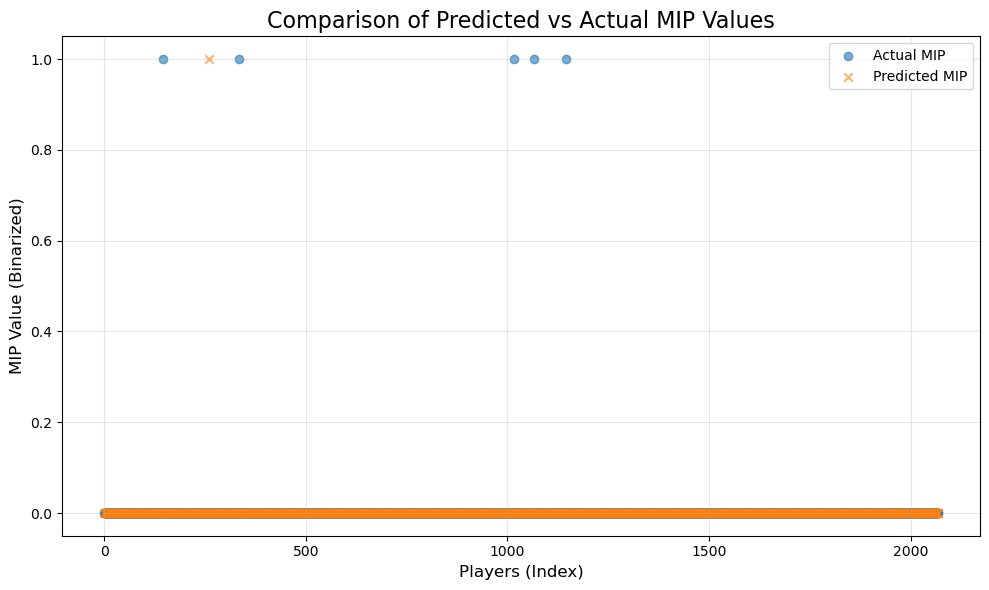

In [62]:
import matplotlib.pyplot as plt

# Create a DataFrame to compare predicted vs actual
comparison_df = data.loc[X_test.index, ['player', 'season']]
comparison_df['actual_mip'] = y_test.values
comparison_df['predicted_mip'] = y_pred

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(
    range(len(comparison_df)),
    comparison_df['actual_mip'],
    label='Actual MIP',
    alpha=0.6,
    marker='o'
)
plt.scatter(
    range(len(comparison_df)),
    comparison_df['predicted_mip'],
    label='Predicted MIP',
    alpha=0.6,
    marker='x'
)

# Add labels and legend
plt.title("Comparison of Predicted vs Actual MIP Values", fontsize=16)
plt.xlabel("Players (Index)", fontsize=12)
plt.ylabel("MIP Value (Binarized)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

Mean Squared Error (MSE): 0.0015772038869015
R² Score: 0.054286387423843396


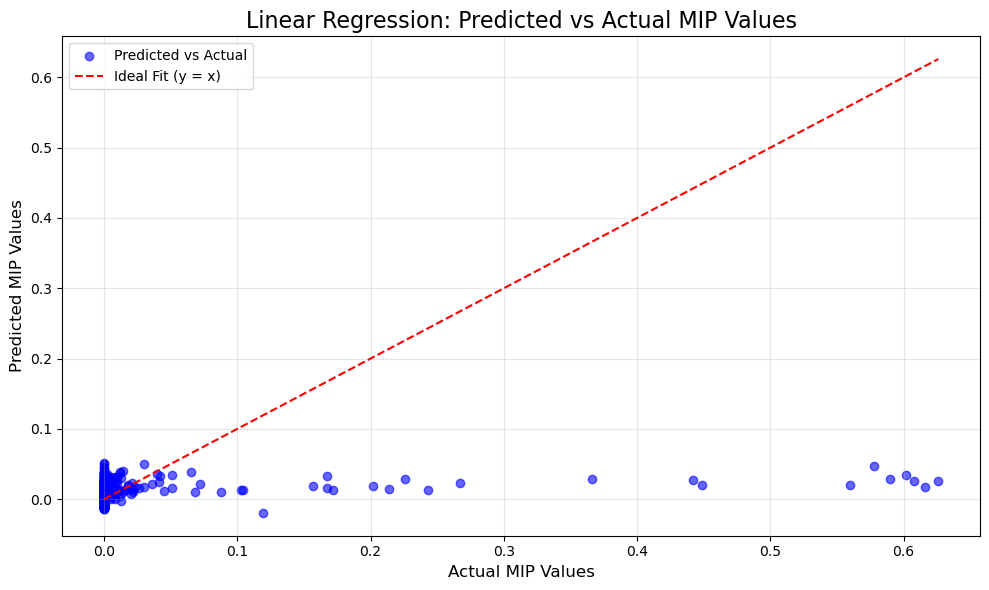

Feature Importance (Coefficients):
fga             1.022890e+07
fg              2.294107e+06
ft              9.301410e+05
x3p             4.963157e+05
trb             4.561202e+05
pos_SG          1.186039e+04
pos_PF          1.186039e+04
pos_SF          1.186039e+04
pos_PG          1.186039e+04
pos_C           1.186039e+04
dpoy            5.359753e-03
stl             1.029502e-04
blk             2.527345e-05
ast             1.855102e-05
gs              1.716111e-05
tov             1.460967e-05
pf              6.351141e-06
age            -8.878734e-07
mp             -9.495677e-06
fta            -6.616347e-05
g              -6.847332e-05
x2p_percent    -2.720799e-04
ft_percent     -6.592242e-04
experience     -6.947433e-04
fg_percent     -1.946480e-03
x3p_percent    -2.831245e-03
e_fg_percent   -4.789394e-03
smoy           -1.645156e-02
nba roy        -2.588485e-02
nba mvp        -5.217807e-02
x2p            -4.338253e+05
orb            -4.561202e+05
drb            -4.561202e+05
pts     

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare features (X) and continuous target (y)
X = data.drop(columns=['mip', 'player', 'season', 'player_id', 'seas_id'])  # Exclude irrelevant columns
y = data['mip']  # Use continuous MIP values as the target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict MIP values for the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual', color='blue')
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red',
    linestyle='--',
    label='Ideal Fit (y = x)'
)

# Add labels, title, and legend
plt.title("Linear Regression: Predicted vs Actual MIP Values", fontsize=16)
plt.xlabel("Actual MIP Values", fontsize=12)
plt.ylabel("Predicted MIP Values", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

# Print feature importance (coefficients)
print("Feature Importance (Coefficients):")
coefficients = pd.Series(linear_model.coef_, index=X.columns).sort_values(ascending=False)
print(coefficients)
